# Hybrid Classic-Quantum Systems - Third Assignment #

You should fill in this Jupyter notebook in order to complete the assignment. Here a small recap of the rules:

* You should **NOT** modify the functions that are already provided in the notebook, unless it is strictly necessary;
* If you want to modify the given functions, please, provide an explanation of why you had to;
* You can define new functions, as soon as they are well commented;
* You can import all libraries you want, as soon as you justify their utilization;
* You can add new cells, as soon as you do not remove the cells where you are supposed to comment your solution;
* This is a group assignment. The maximum number of people is 3;
* Your solution should be commented and accompanied by a small description - you can add additional cells if needed;
* For any issue and doubt, please do not hesitate to use the forum or to write me an email.

# Preliminaries #

## Bin Packing Problem (BPP) ##
The bin packing problem (BPP) is an optimization problem. The final goal is to fit items of different sizes into a finite number of bins, each of a fixed given capacity, minimizing the number of bins used. The problem has many applications, ranging from logistics, multi-processor scheduling.

Computationally, the problem is NP-hard, and the corresponding decision problem, deciding if items can fit into a specified number of bins, is NP-complete.
![np-complete](https://imgs.xkcd.com/comics/np_complete.png)

## Mathematical formulation ##
The objective function of BPP is to minimize the number of bins used, more formally,
\begin{align} \label{eqn:bpp}
    & {\min}\
    & &  \sum_{j=1}^{K} B_j \\
    & {\text{subject to}}
    & & g(x_{ij}) = \sum_{j=1}^{K} x_{ij} = 1 \qquad \forall i \\
    & & & h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} \le C*B_j \qquad \forall j
\end{align}

The constraint $g(x)$ implies that each task can be packed into at most one CPU, and constraint $h(x_{ij})$ says that the requirements of each task can not exceed the given $C$ capacity. In this paper, BPP can be considered as a mixture of inequality and equality-constrained optimization problems.

# Loading BPP instances #
First of all, we focus on generating instances of BPP to be used for the evaluation. Each instance is structured in the following way:

$[[w_0, w_1, ..., w_n], C, B, items]$, such that:
* $w_i$ is the weight of item $i$;
* $C$ is the capacity of each bin;
* $B$ is the number of bins;
* $items$ is the number of items

We pre-generated the instances for you and saved them in an attached binary file. You can read them in your code by using the following code:

In [27]:
import pickle

def read_list(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [28]:
# You might need to reupload bpp_instances
instances = read_list("bpp_instances")

# Transforming BPP into a QUBO #
QUBO is a mathematical model that is used to represent combinatorial optimization problems in which the variables are binary $\{0,1\}$ and the objective function with constraints is quadratic. We employ QUBO for BPP because it provides a framework for representing combinatorial optimization problems in a form that can be efficiently solved using quantum computing algorithms designed for QUBO problems, such as VQE or QAOA.

## Slack Variables + Quadratic Penalty Encoding ##
Qiskit Optimization provides with QuadraticProgram a very generic and powerful representation for optimization problems. However, usually, optimization algorithms cannot handle all possible types of problems that can be modelled, but only a sub-class. Many available quantum optimization algorithms can handle Quadratic Unconstrained Binary Optimization (QUBO) problems. To do so, first, it is necessary to convert a given optimization problem into a QUBO.

Qiskit Optimization provides converters to achieve this conversion whenever possible. More precisely, Qiskit Optimization provides the following converters:
* *InequalityToEquality*: converts inequality constraints into equality constraints with additional slack variables.
* *IntegerToBinary* : converts integer variables into binary variables and corresponding coefficients.
* *LinearEqualityToPenalty* : convert equality constraints into additional terms of the object function.
* *QuadraticProgramToQubo* : a wrapper for IntegerToBinary and LinearEqualityToPenalty for convenience.
More information available at: https://qiskit.org/documentation/stable/0.19/tutorials/optimization/2_converters_for_quadratic_programs.html

## Penalty-Based Encoding ##

### Define penalties ###
To enforce the constraints, we introduce penalty terms to the objective function. These terms penalize solutions that violate the constraints. Firsts, we rewrite constraints $g(x_{ij})$ and $h(x_{ij})$ as follows,
     \begin{align*}
        g(x_{ij}) = \sum_{j=1}^{K} x_{ij} - 1 = 0 \qquad \forall i \\
        h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} - C \cdot B_j \le 0 \qquad \forall j \\
    \end{align*}
    Second, introduce penalty functions $p_1(\lambda, g(x))$ and $p_2(\beta, h(x))$ with coefficients $\{\lambda, \beta\} \geq 0 $
    \begin{equation}\label{penalty1}
        p_1(\lambda, g(x_{ij})) =
        \begin{cases}
            0 & \text{if $g(x_{ij}) \leq 0$} \\
            \lambda g(x_{ij}) & \text{if $g(x_{ij}) > 0$}
        \end{cases}
    \end{equation}
    \begin{equation}\label{penalty2}
        p_2(\beta, h(x_{ij})) =
        \begin{cases}
            0 & \text{if $h(x_{ij}) \leq 0$} \\
            \beta h(x_{ij}) & \text{if $h(x_{ij}) > 0$}
        \end{cases}
    \end{equation}
    
In literature, there are multiple methods for penalization such as the exterior penalty function and interior penalty function.

### Injecting Penalties in the Model ###
To get the final QUBO form we combine penalties with objective function and get

\begin{equation}
    \mathcal{F} = \sum_{j=1}^{K} B_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}

### Examples of penalty functions ###
* https://www.stat.cmu.edu/~ryantibs/convexopt-F13/scribes/lec16.pdf
* https://www.rose-hulman.edu/~bryan/lottamath/penalty.pdf

## YOUR TASK ##
* Apply slack + quadratic penalty
* Apply penalty-based encoding using three functions

In [29]:
install = False
if (install):
  !pip install qiskit
  !pip install qiskit_optimization
  !pip install qiskit-optimization[cplex]
  !pip install docplex
  !pip install cplex
  !pip install qiskit-aer
  !pip install seaborn

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

from qiskit_optimization.converters import InequalityToEquality, IntegerToBinary, LinearEqualityToPenalty

In [31]:
print(instances)

[[[55, 40, 25, 50], 100, 3, 4], [[80, 20, 55, 15], 120, 3, 4], [[70, 35, 15, 70], 100, 3, 4], [[10, 55, 65, 35], 120, 3, 4], [[35, 40, 45, 50], 100, 3, 4], [[95, 50, 45, 25], 120, 3, 4], [[60, 25, 75, 25], 100, 3, 4], [[55, 10, 60], 120, 2, 3], [[55, 60, 35], 100, 2, 3], [[40, 95, 60], 120, 2, 3], [[55, 50, 5], 100, 2, 3], [[100, 30, 35], 120, 2, 3], [[50, 50, 30], 100, 2, 3], [[30, 60, 75], 120, 2, 3], [[25, 20, 15, 20, 5], 100, 1, 5], [[10, 40, 40, 20, 5], 120, 1, 5], [[10, 20, 25, 15, 25], 100, 1, 5], [[5, 10, 15, 25, 35], 120, 1, 5], [[5, 40, 10, 5, 35], 100, 1, 5], [[40, 35, 10, 15, 20], 120, 1, 5], [[10, 15, 25, 10, 15], 100, 1, 5]]


In [32]:
"""
  Defines the classical model for BPP.

  n: number of items
  m: number of bins
  w: weights of the items
  C: capacity of the bins

  returns: classical model for BPP, according to the input parameters
"""
def get_classical_model(n, m, w, C):

  mdl = Model("BPP")

  B = mdl.binary_var_list(m, name='B')
  x = mdl.binary_var_matrix(m, n, name='x')
  mdl.minimize(mdl.sum(B[j] for j in range(m)))

  # adding constraints
  for i in range(n):
      mdl.add_constraint(mdl.sum(x[j, i] for j in range(m)) == 1)

  for j in range(m):
      mdl.add_constraint(mdl.sum(w[i] * x[j, i] for i in range(n)) <= C * B[j])

  return mdl


In [33]:
# Load quadratic program from docplex model
mdl = get_classical_model(instances[0][3], instances[0][2], instances[0][0], instances[0][1])
qp = from_docplex_mp(mdl)
print(type(qp))
print(qp.prettyprint())

<class 'qiskit_optimization.problems.quadratic_program.QuadraticProgram'>
Problem name: BPP

Minimize
  B_0 + B_1 + B_2

Subject to
  Linear constraints (7)
    x_0_0 + x_1_0 + x_2_0 == 1  'c0'
    x_0_1 + x_1_1 + x_2_1 == 1  'c1'
    x_0_2 + x_1_2 + x_2_2 == 1  'c2'
    x_0_3 + x_1_3 + x_2_3 == 1  'c3'
    -100*B_0 + 55*x_0_0 + 40*x_0_1 + 25*x_0_2 + 50*x_0_3 <= 0  'c4'
    -100*B_1 + 55*x_1_0 + 40*x_1_1 + 25*x_1_2 + 50*x_1_3 <= 0  'c5'
    -100*B_2 + 55*x_2_0 + 40*x_2_1 + 25*x_2_2 + 50*x_2_3 <= 0  'c6'

  Binary variables (15)
    B_0 B_1 B_2 x_0_0 x_0_1 x_0_2 x_0_3 x_1_0 x_1_1 x_1_2 x_1_3 x_2_0 x_2_1
    x_2_2 x_2_3



In [34]:
"""
  Simplifies the quadratic problem by reducing variables related to reasonable assumptions.

  qp: quadratic problem with BPP
  n: number of items
  m: number of bins
  w: weights of the items
  C: capacity of the bins
"""
def simplify_quadratic_problem(qp, m, w, C):
  min_bins = int(np.ceil(np.sum(w)/C))

  # The minimum number of bins is the one necessary to cover the sum of the items' weight
  # That means the first num_bins bins will be used
  for i in range(min_bins):
    qp = qp.substitute_variables({f"B_{i}": 1})

  # We can assume the first item will be allocated to the first bin
  # This is true because all bins have the same capacity and the problem is assumed feasible
  qp = qp.substitute_variables({"x_0_0": 1})

  # The first item is not in any other bin
  for i in range(1, m):
    qp = qp.substitute_variables({f"x_{i}_0": 0})

  return qp

In [35]:
qp = simplify_quadratic_problem(qp, instances[0][2], instances[0][0], instances[0][1])
print(qp.prettyprint())

Problem name: BPP

Minimize
  B_2 + 2

Subject to
  Linear constraints (6)
    x_0_1 + x_1_1 + x_2_1 == 1  'c1'
    x_0_2 + x_1_2 + x_2_2 == 1  'c2'
    x_0_3 + x_1_3 + x_2_3 == 1  'c3'
    40*x_0_1 + 25*x_0_2 + 50*x_0_3 <= 45  'c4'
    40*x_1_1 + 25*x_1_2 + 50*x_1_3 <= 100  'c5'
    -100*B_2 + 40*x_2_1 + 25*x_2_2 + 50*x_2_3 <= 0  'c6'

  Binary variables (10)
    B_2 x_0_1 x_0_2 x_0_3 x_1_1 x_1_2 x_1_3 x_2_1 x_2_2 x_2_3



In [36]:
"""
  Applies penalty-based encoding to the quadratic problem.

  qp: instace of a quadratic problem

  returns: qubo version of a quadratic problem
"""
def apply_penalty_encoding(qp):
  ineq_to_eq = InequalityToEquality()
  qp_eq = ineq_to_eq.convert(qp)

  int_to_bin = IntegerToBinary()
  qp_eq_bin = int_to_bin.convert(qp_eq)

  lin_eq_to_penalty = LinearEqualityToPenalty()
  qubo = lin_eq_to_penalty.convert(qp_eq_bin)

  return qubo

qubo_test = apply_penalty_encoding(qp)
print(f"The number of variables is {qubo_test.get_num_vars()}")
print(qubo_test.prettyprint())


The number of variables is 30
Problem name: BPP

Minimize
  20000*B_2^2 - 400*B_2*c6@int_slack@0 - 800*B_2*c6@int_slack@1
  - 1600*B_2*c6@int_slack@2 - 3200*B_2*c6@int_slack@3 - 6400*B_2*c6@int_slack@4
  - 12800*B_2*c6@int_slack@5 - 14800*B_2*c6@int_slack@6 - 16000*B_2*x_2_1
  - 10000*B_2*x_2_2 - 20000*B_2*x_2_3 + 2*c4@int_slack@0^2
  + 8*c4@int_slack@0*c4@int_slack@1 + 16*c4@int_slack@0*c4@int_slack@2
  + 32*c4@int_slack@0*c4@int_slack@3 + 64*c4@int_slack@0*c4@int_slack@4
  + 56*c4@int_slack@0*c4@int_slack@5 + 8*c4@int_slack@1^2
  + 32*c4@int_slack@1*c4@int_slack@2 + 64*c4@int_slack@1*c4@int_slack@3
  + 128*c4@int_slack@1*c4@int_slack@4 + 112*c4@int_slack@1*c4@int_slack@5
  + 32*c4@int_slack@2^2 + 128*c4@int_slack@2*c4@int_slack@3
  + 256*c4@int_slack@2*c4@int_slack@4 + 224*c4@int_slack@2*c4@int_slack@5
  + 128*c4@int_slack@3^2 + 512*c4@int_slack@3*c4@int_slack@4
  + 448*c4@int_slack@3*c4@int_slack@5 + 512*c4@int_slack@4^2
  + 896*c4@int_slack@4*c4@int_slack@5 + 392*c4@int_slack@5^2
 

In [37]:
"""
  Defines the QUBO model for BPP.

  n: number of items
  m: number of bins
  w: weights of the items
  C: capacity of the bins
  simplify: If True, simplifies the problem by reducing number of variables

  returns: QUBO model for BPP (quadratic problem), according to the input parameters
"""
def get_qubo(n, m, w, C, simplify = True):
    mdl = get_classical_model(n, m, w, C)
    qp = from_docplex_mp(mdl)
    if simplify:
      qp = simplify_quadratic_problem(qp, m, w, C)
    qubo = apply_penalty_encoding(qp)
    return qubo

# Encoding QUBO into ISING Hamiltonian #
The next step is to encode the classical QUBO formulation into a quantum state. There exist techniques to encode classical data into quantum such as basis encoding, amplitude encoding, and angle encoding. In this paper, we apply basis encoding, for which any quantum basis can be chosen, but the common way for doing so is to choose basis $\{-1,1\}$ as follows:
\begin{align}
\label{eqn:to_ising}
    \begin{split}
    x_i = \frac{1-z_i}{2}\\
    z_i*z_j = \sigma_Z^i \otimes \sigma_Z^j \\
    z_i = \sigma_Z^i
    \end{split}
\end{align}
where $\sigma_Z^i$ denotes the Pauli-Z matrix
$\begin{pmatrix}
  1 & 0\\
  0 & -1
\end{pmatrix}$ on the $i$-th qubit.
The eigenvalues of $\text{I} - \frac{Z}{2}$ are $\{-1,1\}$ with corresponding eigenstates $|0\rangle$ and $|1\rangle$. Thus, we switch from Z to $\text{I} - \frac{Z}{2}$, and rewrite the problem as BPP Ising hamiltonian,
\begin{equation} \label{eqn:final_hamiltonian}
    H_{bpp}= \sum_{j=1}^{K} \sigma_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}
where $g_j$ and $h_i$ are now functions of $\sigma$.

## YOUR TASK: Encoding the QUBO as an Ising Hamiltonian ##

In [38]:
"""
  Encodes a quadratic problem instance representing a QUBO as a Ising Hamiltonian.

  qubo: quadratic problem representing a QUBO

  returns: Operator instance representing the Ising Hamiltonian
"""
def encode_qubo_as_ising(qubo):
  operator, _ = qubo.to_ising()
  return operator

# This step is not needed for solving the problem, since the optimizers
# convert the QUBO into a Ising Hamiltonian under the hood
print(qubo_test)
operator = encode_qubo_as_ising(qubo_test)
print(qubo_test)
print(operator)

minimize 20000*B_2^2 - 400*B_2*c6@int_slack@0 - 800*B_2*c6@int_slack@1 - 1600*B_2*c6@int_slack@2 - 3200*B_2*c6@int_slack@3 - 6400*B_2*c6@int_slack@4 - 12800*B_2*c6@int_slack@5 - 14800*B_2*c6@int_slack@6 - 16000*B_2*x_2_1 - 10000*B_2*x_2_2 - 20000*B_2*x_2_3 + 2*c4@int_slack@0^2 + 8*c4@int_slack@0*c4@int_slack@1 + 16*c4@int_slack@0*c4@int_slack@2 + 32*c4@int_slack@0*c4@int_slack@3 + 64*c4@int_slack@0*c4@int_slack@4 + 56*c4@int_slack@0*c4@int_slack@5 + 8*c4@int_slack@1^2 + 32*c4@int_slack@1*c4@int_slack@2 + 64*c4@int_slack@1*c4@int_slack@3 + 128*c4@int_slack@1*c4@int_slack@4 + 112*c4@int_slack@1*c4@int_slack@5 + 32*c4@int_slack@2^2 + 128*c4@int_slack@2*c4@int_slack@3 + 256*c4@int_slack@2*c4@int_slack@4 + 224*c4@int_slack@2*c4@int_slack@5 + 128*c4@int_slack@3^2 + 512*c4@int_slack@3*c4@int_slack@4 + 448*c4@int_slack@3*c4@int_slack@5 + 512*c4@int_slack@4^2 + 896*c4@int_slack@4*c4@int_slack@5 + 392*c4@int_slack@5^2 + 2*c5@int_slack@0^2 + 8*c5@int_slack@0*c5@int_slack@1 + 16*c5@int_slack@0*c5@

# Solving BPP instances #
Solve each problem instances using different methods:
## CPLEX optimizer ##
Classic optimizer, to be used as baseline with all the others.

In [39]:
"""
  Plots the result of an optimizer.

  result: result of the optimizer
  n: number of items
  m: number of bins
  w: weights of the items
  C: capacity of the bins
  simplify: informs whether the problem was simplified or not
"""
def plot_result(result, n, m, w, C, simplify = True):
  results = result.x

  if simplify:
    # Re-add the simplification variables
    min_bins = int(np.ceil(np.sum(w)/C))
    for _ in range(min_bins):
      results = np.insert(results, 0, 0) # Unused bins
    results = np.insert(results, m, 1) # First item always at first bin
    for bin in range(1, m): # First item is only in first bin
      results = np.insert(results, m + bin * n, 0)

  plt.figure()

  items = results[m:m + m * n].reshape(m, n) * w

  indices = np.arange(m)
  plt.bar(indices, items[:, 0], label=f"Item {0}")

  item_nums = items[:, 0]
  for j in range(1, n):
      plt.bar(indices, items[:, j], bottom=item_nums, label=f"Item {j}")
      item_nums += items[:, j]

  plt.hlines(C, -0.5, m - 0.5, linestyle="--", color="r", label="Capacity")
  plt.xticks(indices)
  plt.xlabel("Bin")
  plt.ylabel("Weight")
  plt.legend()
  plt.show()

In [40]:
from docplex.mp.model import Model
from qiskit_optimization.algorithms import CplexOptimizer
import time
import pandas as pd

In [41]:
"""
  Solves the classical version of BPP and plots the result.

  qp: quadratic problem representing BPP
"""
def solve_classical(instance):
  
  n = instance[3]
  m = instance[2]
  w = instance[0]
  C = instance[1]

  mdl = get_classical_model(n, m, w, C)
  qp = from_docplex_mp(mdl)
  qp = simplify_quadratic_problem(qp, m, w, C)

  optimizer = CplexOptimizer()

  start_time = time.perf_counter()
  result = optimizer.solve(qp)
  end_time = time.perf_counter()

  print("Elapsed time:", end_time - start_time)
  
  print(result)
  plot_result(result, n, m, w, C)

  return result.fval, end_time - start_time, result.status == 'SUCCESS'

Elapsed time: 0.01744870003312826
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


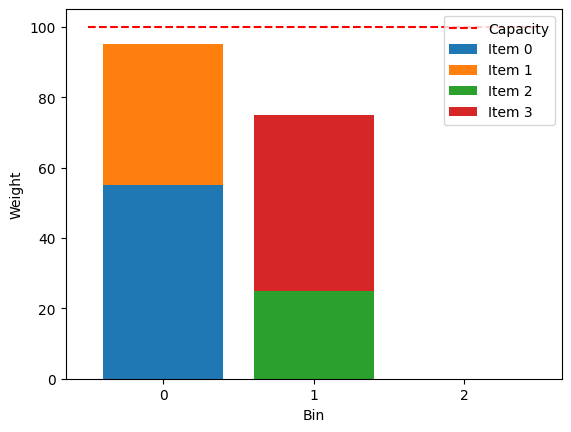

(2.0, 0.01744870003312826, False)

In [42]:
solve_classical(instances[0])

## QAOA solution ##


In [43]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.optimizers import NELDER_MEAD
from qiskit.algorithms.optimizers import SPSA
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer
from qiskit.primitives import Sampler
from qiskit.primitives import BackendSampler
from qiskit import Aer
from qiskit.providers.fake_provider import FakeWashingtonV2
import time
import pandas as pd

In [44]:
def solve_qaoa(instance, optimizer, backend, shots, p, warm_start = False):
  
  n = instance[3]
  m = instance[2]
  w = instance[0]
  C = instance[1]

  qubo = get_qubo(n, m, w, C)

  if shots is None:
    sampler = BackendSampler(backend=backend)
  else:
    sampler = Sampler(shots=shots)

  qaoa = QAOA(sampler, optimizer, reps=p)

  # backend = Aer.get_backend("qasm_simulator")
  if warm_start:
    optimizer = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa)
  else:
    optimizer = MinimumEigenOptimizer(qaoa)

  start_time = time.perf_counter()
  result = optimizer.solve(qubo)
  end_time = time.perf_counter()

  print("Elapsed time:", end_time - start_time)

  print(result)
  plot_result(result, n, m, w, C)

  return result.fval, end_time - start_time, result.status == 'SUCCESS'

## Warm start QAOA ##

Main code

In [45]:
def solve_and_get_metrics(instance, backend_name, backend, optimizer_name, optimizer, optimizer_iteration, shots, p, dfs):

    optimum, time, found = solve_qaoa(instance, optimizer=optimizer, backend=backend, shots=shots, p=p)
    dfs['qaoa'].append({'instance': instances.index(instance), 'time': time, 'optimum': optimum, 
                        'found': found, 'optimizer': optimizer_name, 'backend': backend_name, 'shots': shots, 
                        'optimizer_iteration': optimizer_iteration, 'p': p}, ignore_index=True)

    optimum, time, found = solve_qaoa(instance, optimizer=optimizer, backend=backend, shots=shots, p=p, warm_start=True)
    dfs['warm_start_qaoa'] = dfs['warm_start_qaoa'].append({'instance': instances.index(instance), 'time': time, 'optimum': optimum, 
                                   'found': found, 'optimizer': optimizer_name, 'backend': backend_name, 'shots': shots, 
                                   'optimizer_iteration': optimizer_iteration, 'p': p}, ignore_index=True)

In [46]:
columns_quantum = ['instance', 'time', 'optimum', 'found', 'optimizer', 'backend', 'shots', 'optimizer_iteration','p']
columns_classical = ['instance', 'time', 'optimum', 'found']

backends = {'aer_simulator': Aer.get_backend("qasm_simulator"), 'fake_manila': FakeWashingtonV2()}
solvers = ['cplex', 'qaoa', 'warm_start_qaoa']

p_list = [1, 2, 3, 4, 5]
optimizers = {'cobyla': COBYLA(), 'nelder_mead': NELDER_MEAD(), 'spsa': SPSA()}
shots_list = [200, 400, 600, 800, 1000]
optimizer_iterations = [250, 500, 750, 1000]

dfs = {}
dfs['cplex'] = pd.DataFrame(columns=columns_classical)
dfs['qaoa'] = pd.DataFrame(columns=columns_quantum)
dfs['warm_start_qaoa'] = pd.DataFrame(columns=columns_quantum)

Elapsed time: 0.017345299944281578
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


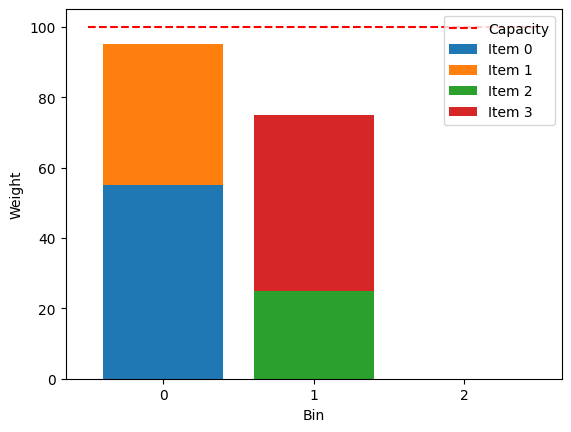

C:\Users\elipi\AppData\Local\Temp\ipykernel_8948\3211901063.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs['cplex'] = pd.concat([dfs['cplex'], pd.DataFrame([new_row])], ignore_index=True)


Elapsed time: 0.014560899930074811
fval=2.0, B_2=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_1=1.0, x_1_2=1.0, x_1_3=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


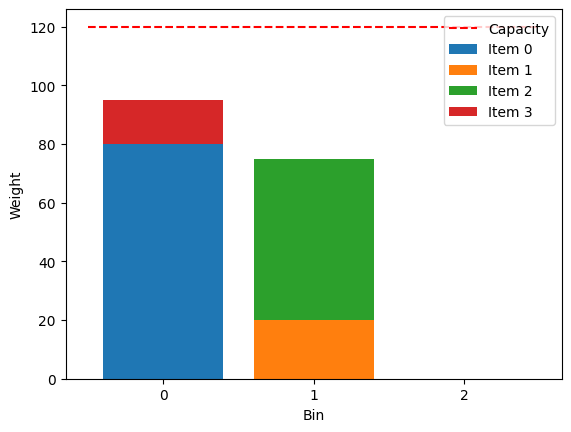

Elapsed time: 0.015391899971291423
fval=3.0, B_2=1.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


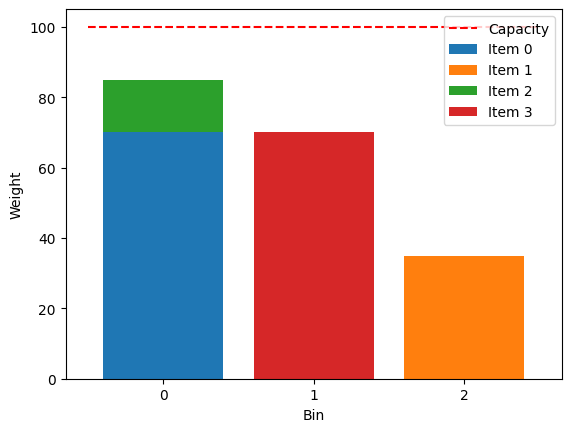

Elapsed time: 0.015338600031100214
fval=2.0, B_2=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_1=1.0, x_1_2=1.0, x_1_3=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


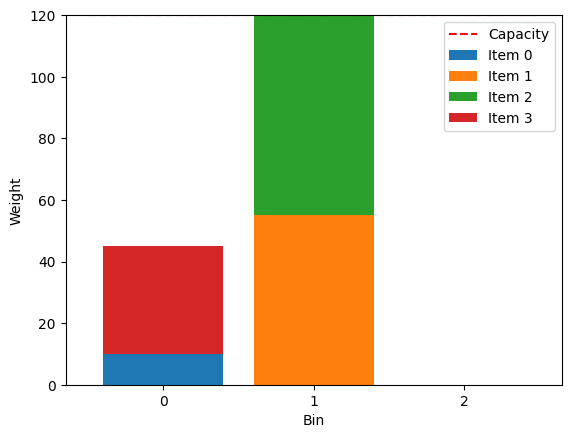

Elapsed time: 0.018424299894832075
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


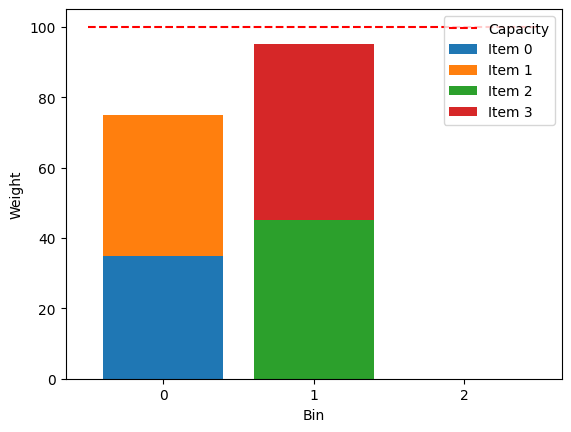

Elapsed time: 0.014657699968665838
fval=2.0, B_2=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=0.0, x_1_1=1.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


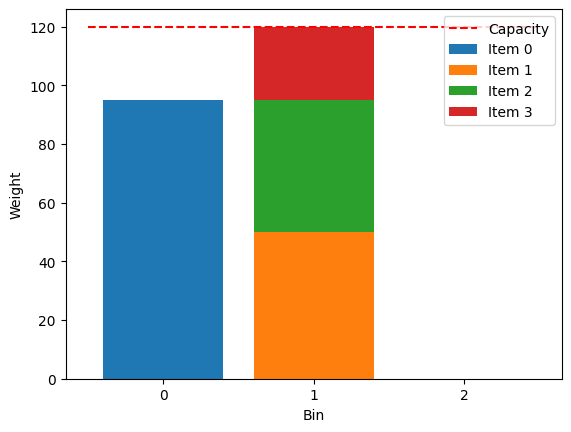

Elapsed time: 0.016983099980279803
fval=2.0, B_2=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=1.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, status=SUCCESS


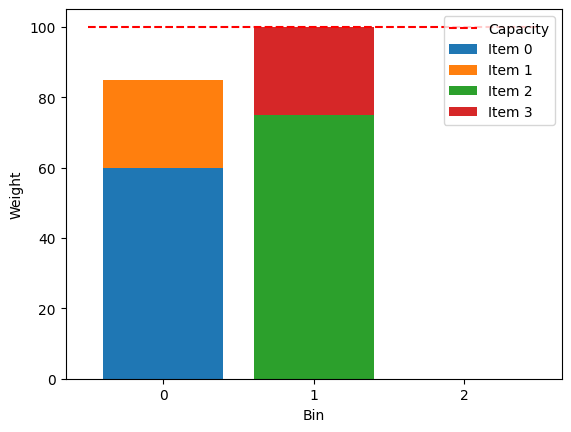

Elapsed time: 0.01403980003669858
fval=2.0, x_0_1=0.0, x_0_2=0.0, x_1_1=1.0, x_1_2=1.0, status=SUCCESS


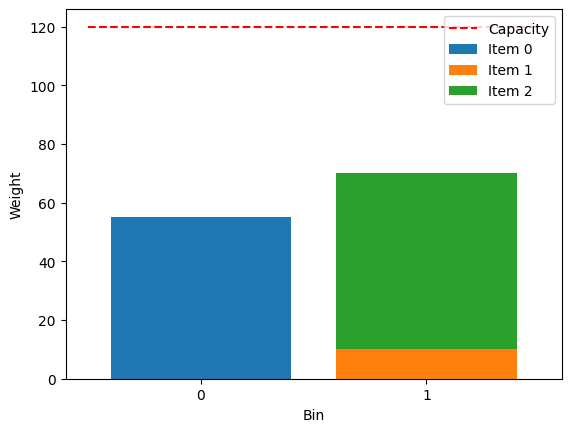

Elapsed time: 0.012757900054566562
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


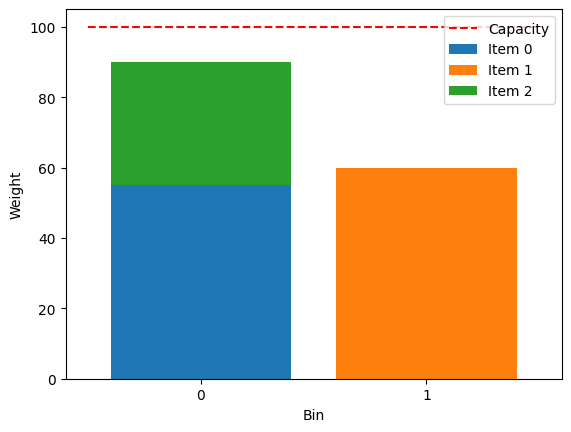

Elapsed time: 0.013437099987640977
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


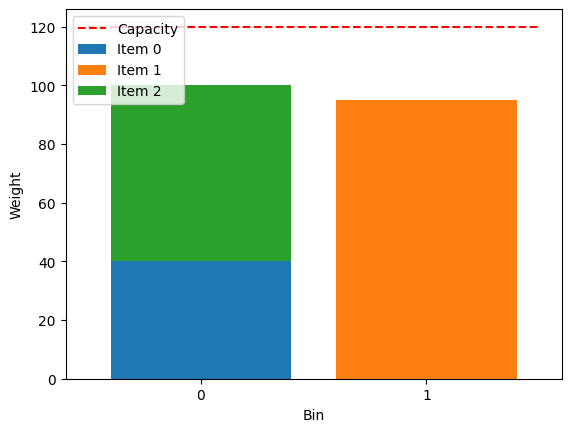

Elapsed time: 0.012080600019544363
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


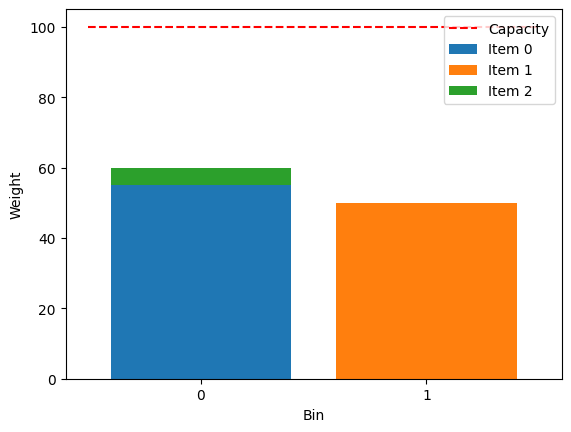

Elapsed time: 0.012642899993807077
fval=2.0, x_0_1=0.0, x_0_2=0.0, x_1_1=1.0, x_1_2=1.0, status=SUCCESS


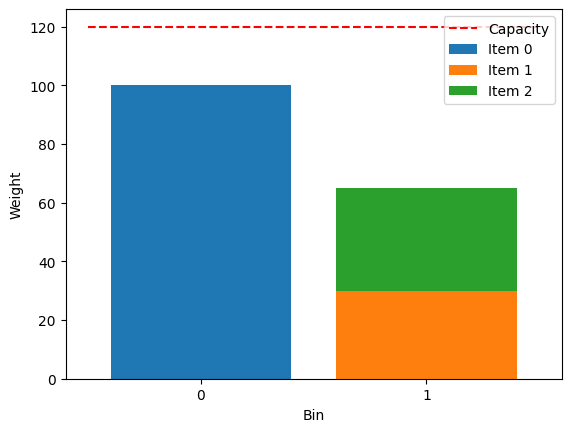

Elapsed time: 0.012846499914303422
fval=2.0, x_0_1=1.0, x_0_2=0.0, x_1_1=0.0, x_1_2=1.0, status=SUCCESS


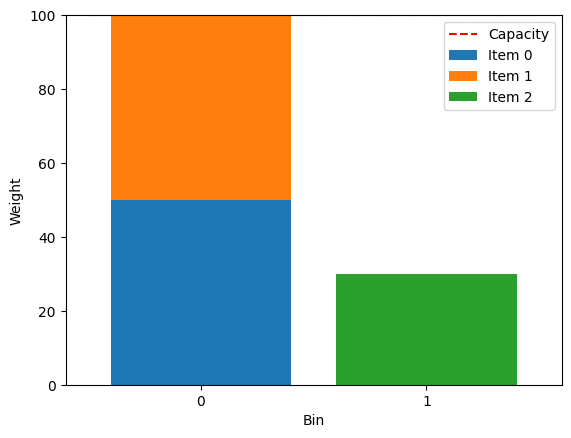

Elapsed time: 0.011590400012210011
fval=2.0, x_0_1=0.0, x_0_2=1.0, x_1_1=1.0, x_1_2=0.0, status=SUCCESS


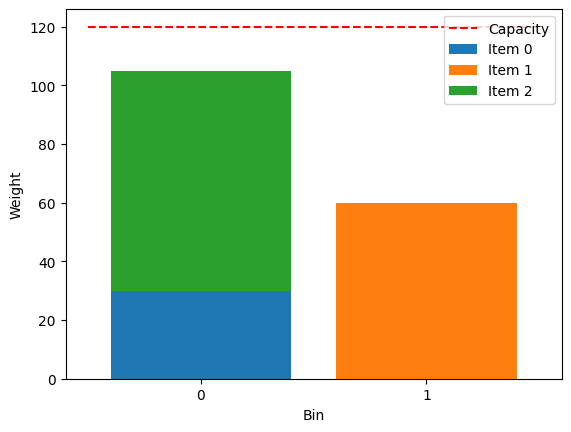

Elapsed time: 0.011539099970832467
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


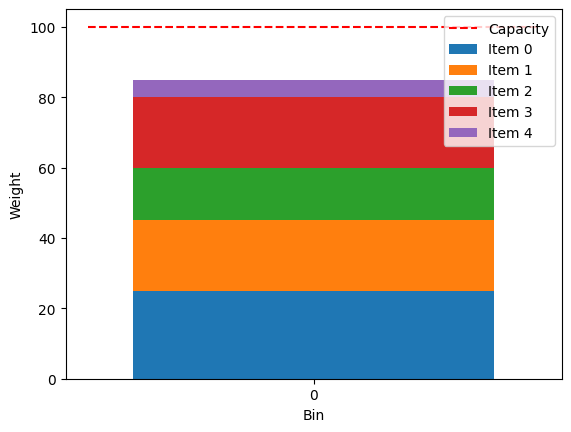

Elapsed time: 0.01250319997780025
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


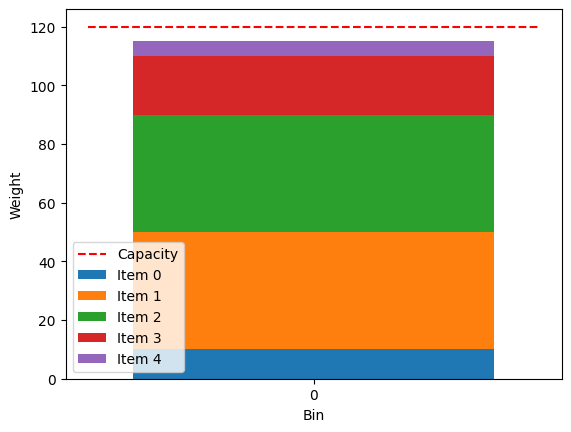

Elapsed time: 0.013094200054183602
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


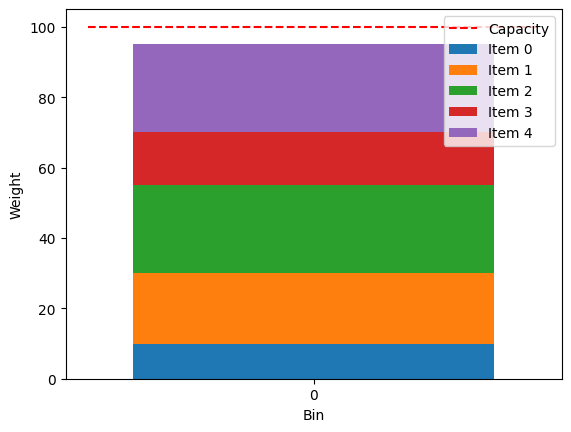

Elapsed time: 0.012966100010089576
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


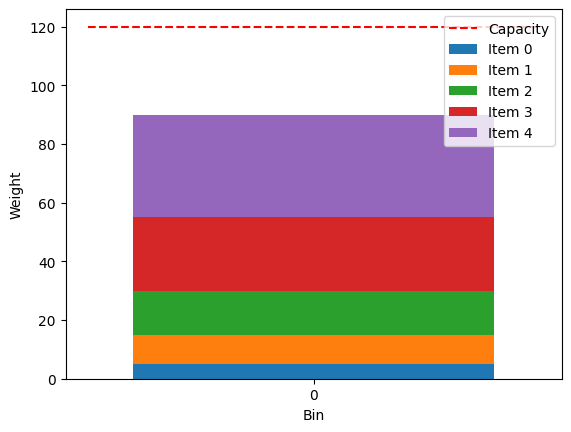

Elapsed time: 0.013688499922864139
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


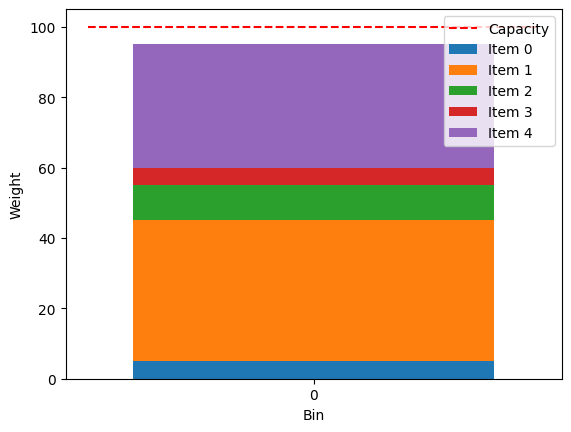

Elapsed time: 0.015534400008618832
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


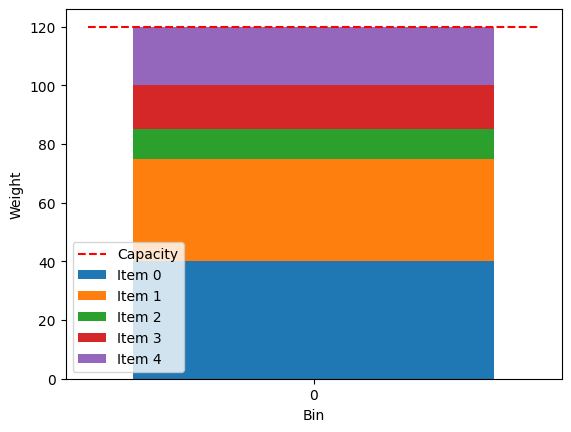

Elapsed time: 0.014246399980038404
fval=1.0, x_0_1=1.0, x_0_2=1.0, x_0_3=1.0, x_0_4=1.0, status=SUCCESS


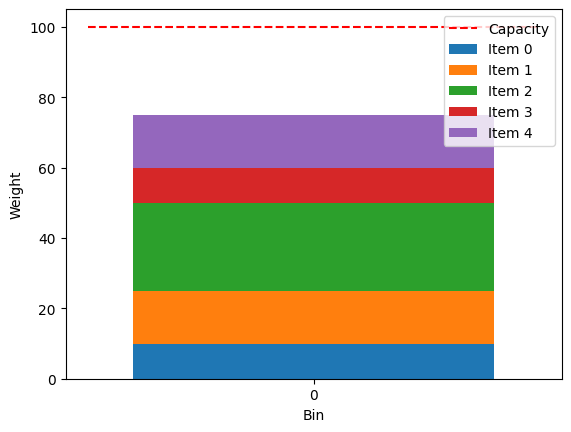

In [47]:
run_classical = False
if (run_classical):
    for instance in instances:
        optimum, elapsed_time, found = solve_classical(instance)
        new_row = {'instance': instances.index(instance), 'time': elapsed_time, 'optimum': optimum, 'found': found}
        dfs['cplex'] = pd.concat([dfs['cplex'], pd.DataFrame([new_row])], ignore_index=True)

In [48]:
# check if any instance exceeds 32 variables
exceeds = False
for instance in instances:
    qubo = get_qubo(instance[3], instance[2], instance[0], instance[1])
    if qubo.get_num_vars() > 32:
        print("[WARNING] Instance", instance, "exceeded 32 variables! The models might fail")
        exceeds = True
if not exceeds:
    print("No instance exceeds 32 variables. Everything should work as expected")

run_quantum = False
if run_quantum:
    for instance in instances:
        for backend_name, backend in backends.items():
            for p in p_list:
                solve_and_get_metrics(instance, backend_name, backend, 'cobyla', optimizers['cobyla'], 1000, None, p, dfs)
            for optimizer_name, optimizer in optimizers.items():
                solve_and_get_metrics(instance, backend_name, backend, optimizer_name, optimizer, 1000, None, 2, dfs)
            for optimizer_iteration in optimizer_iterations:
                cobyla_optimizer = COBYLA(maxiter=optimizer_iteration)
                solve_and_get_metrics(instance, backend_name, backend, 'cobyla', cobyla_optimizer, optimizer_iteration, None, 2, dfs)
        for shots in shots_list:
            solve_and_get_metrics(instance, "aer_simulator", None, 'cobyla', optimizers['cobyla'], 1000, shots, 2, dfs)

No instance exceeds 32 variables. Everything should work as expected


# Evaluation #

Evaluate quantum solutions in comparison with classic solution using the following metrics:
* Running time;
* Mean square error between quantum optimum and classic optimum;
* Number of times each algorithm reaches the optimum;

Evaluation should be performed on the following backends:
* Noiseless simulator (Aer)
* Noisy simulator (choose a noise model)
* BONUS: test on AQT simulator (check https://github.com/qiskit-community/qiskit-aqt-provider)

QAOA should be evaluated using different configurations:
* QAOAAnsatz with $p=[1,5]$
* Optimizers: COBYLA, NelderMead, SLSQP
* Shots: {200, 400, 600, 800, 1000} (Please note that AQT backend is limited to 200 shots)
* Optimizers' iteration: {250, 500, 750, 1000}

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [50]:
def compute_mse(optimizer_name, shots, optimizer_iteration, p):
    qaoa_results = dfs['qaoa'][(dfs['qaoa']['optimizer'] == optimizer_name) 
                               & (dfs['qaoa']['shots'] == shots) 
                               & (dfs['qaoa']['optimizer_iteration'] == optimizer_iteration)
                               & (dfs['qaoa']['p'] == p)]
    classical_results = dfs['cplex']
    mse = np.mean((qaoa_results['optimum'] - classical_results['optimum'])**2)
    return mse

In [51]:
# Compute mean square error for all combinations
mse_results = []

for optimizer_name in optimizers.keys():
    mse = compute_mse(optimizer_name, None, 1000, 2)
    mse_results.append({'optimizer': optimizer_name, 'shots': None, 'optimizer_iteration': 1000, 'mse': mse})
    
for shots in shots_list:
    mse = compute_mse('cobyla', shots, 1000, 2)
    mse_results.append({'optimizer': 'cobyla', 'shots': shots, 'optimizer_iteration': 1000, 'mse': mse})

for optimizer_iteration in optimizer_iterations:
    mse = compute_mse('cobyla', None, optimizer_iteration, 2)
    mse_results.append({'optimizer': 'cobyla', 'shots': None, 'optimizer_iteration': optimizer_iteration, 'mse': mse})

for p in p_list:
    mse = compute_mse('cobyle', None, 1000, p)
    mse_results.append({'optimizer': 'qaoa', 'shots': None, 'optimizer_iteration': 1000, 'mse': mse})
            
# Print mean square error results
for result in mse_results:
    print(f"Optimizer: {result['optimizer']}, Shots: {result['shots']}, Optimizer Iteration: {result['optimizer_iteration']}, MSE: {result['mse']}")


Optimizer: cobyla, Shots: None, Optimizer Iteration: 1000, MSE: nan
Optimizer: nelder_mead, Shots: None, Optimizer Iteration: 1000, MSE: nan
Optimizer: spsa, Shots: None, Optimizer Iteration: 1000, MSE: nan
Optimizer: cobyla, Shots: 200, Optimizer Iteration: 1000, MSE: nan
Optimizer: cobyla, Shots: 400, Optimizer Iteration: 1000, MSE: nan
Optimizer: cobyla, Shots: 600, Optimizer Iteration: 1000, MSE: nan
Optimizer: cobyla, Shots: 800, Optimizer Iteration: 1000, MSE: nan
Optimizer: cobyla, Shots: 1000, Optimizer Iteration: 1000, MSE: nan
Optimizer: cobyla, Shots: None, Optimizer Iteration: 250, MSE: nan
Optimizer: cobyla, Shots: None, Optimizer Iteration: 500, MSE: nan
Optimizer: cobyla, Shots: None, Optimizer Iteration: 750, MSE: nan
Optimizer: cobyla, Shots: None, Optimizer Iteration: 1000, MSE: nan
Optimizer: qaoa, Shots: None, Optimizer Iteration: 1000, MSE: nan
Optimizer: qaoa, Shots: None, Optimizer Iteration: 1000, MSE: nan
Optimizer: qaoa, Shots: None, Optimizer Iteration: 1000,

In [52]:
def plot_results(df):
    

SyntaxError: incomplete input (95856300.py, line 2)